In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from cf_matrix import make_confusion_matrix as cm

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./Data/df_cleaned.csv', index_col=0)
df = df.reset_index(drop=True)

# Removing Sources of Data Leakage

In [3]:
drop_col = ['yards', 'firstdown', 'batted_pass', 'interception',
            'incompletion_type', 'touchdown']

In [4]:
df = df.drop(drop_col, axis=1)

# Model Training

In [5]:
df['play_action'] = df['play_action'].map(lambda x: 1 if x == True else 0)
df['run_pass_option'] = df['run_pass_option'].map(lambda x: 1 if x == True else 0)
df['blitz_y'] = df['blitz_y'].map(lambda x: 1 if x == True else 0)


In [6]:
df.head()

name  complete  att_yards  inside_20  goaltogo  blitz_x  hurry  \
0  Aaron Rodgers       1.0        0.0        0.0       0.0      0.0    0.0   
1  Aaron Rodgers       1.0       13.0        1.0       0.0      0.0    0.0   
2  Aaron Rodgers       1.0        5.0        0.0       0.0      1.0    0.0   
3  Aaron Rodgers       1.0       -4.0        0.0       0.0      0.0    0.0   
4  Aaron Rodgers       1.0       -5.0        0.0       0.0      0.0    0.0   

   knockdown  pocket_time     direction  quarter  yards_to_goal  down  \
0        0.0        3.134   short right      2.0             31     1   
1        0.0        1.820   short right      2.0             14     2   
2        0.0        1.855  short middle      1.0             27     1   
3        0.0        1.191    short left      1.0             32     2   
4        0.0        2.697   short right      1.0             56     2   

   yards_to_first   hash_mark  play_action  run_pass_option  blitz_y  \
0              10  Right Hash            0                0        0   
1               9   Left Hash            0                0        0   
2              10   Left Hash            0                0        1   
3               5  Right Hash            1                1        0   
4               7   Left Hash            0                0        0   

  qb_at_snap  players_rushed pocket_location pass_route  seconds_left_in_half  \
0    Shotgun             4.0          Middle       Flat                   120   
1    Shotgun             4.0          Middle         Go                   858   
2    Shotgun             6.0          Middle      Slant                   913   
3    Shotgun             4.0          Middle  WR Screen                   953   
4    Shotgun             4.0          Middle       Flat                  1203   

  att_dist  
0    short  
1   medium  
2    short  
3   behind  
4   behind

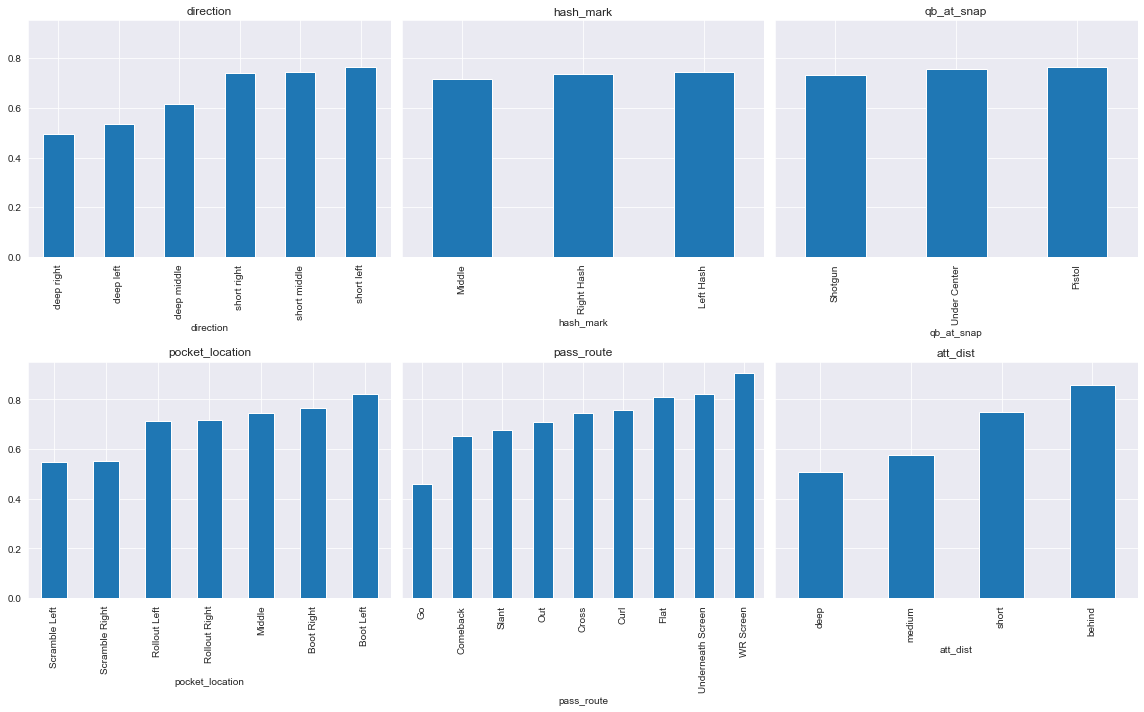

In [7]:
cat = ['direction', 'hash_mark', 'qb_at_snap', 'pocket_location', 'pass_route', 'att_dist']
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(16,10),sharey=True)
for col, ax in zip(cat, axes.flatten()):
    (df.groupby(col)
        .mean()['complete']
        .sort_values()
        .plot
        .bar(ax=ax))
    
    ax.set_title(col)
    
fig.tight_layout()
    


In [8]:
dummies = pd.get_dummies(df[cat], drop_first=True)
dfpre = df.drop(cat, axis=1)
dfpre = pd.concat([dfpre, dummies], axis=1)

In [9]:
scale_cols = ['att_yards', 'pocket_time', 'yards_to_goal', 'yards_to_first', 'players_rushed',
              'seconds_left_in_half', 'quarter', 'down']

array([[<AxesSubplot:title={'center':'att_yards'}>,
        <AxesSubplot:title={'center':'pocket_time'}>,
        <AxesSubplot:title={'center':'yards_to_goal'}>],
       [<AxesSubplot:title={'center':'yards_to_first'}>,
        <AxesSubplot:title={'center':'players_rushed'}>,
        <AxesSubplot:title={'center':'seconds_left_in_half'}>],
       [<AxesSubplot:title={'center':'quarter'}>,
        <AxesSubplot:title={'center':'down'}>, <AxesSubplot:>]],
      dtype=object)

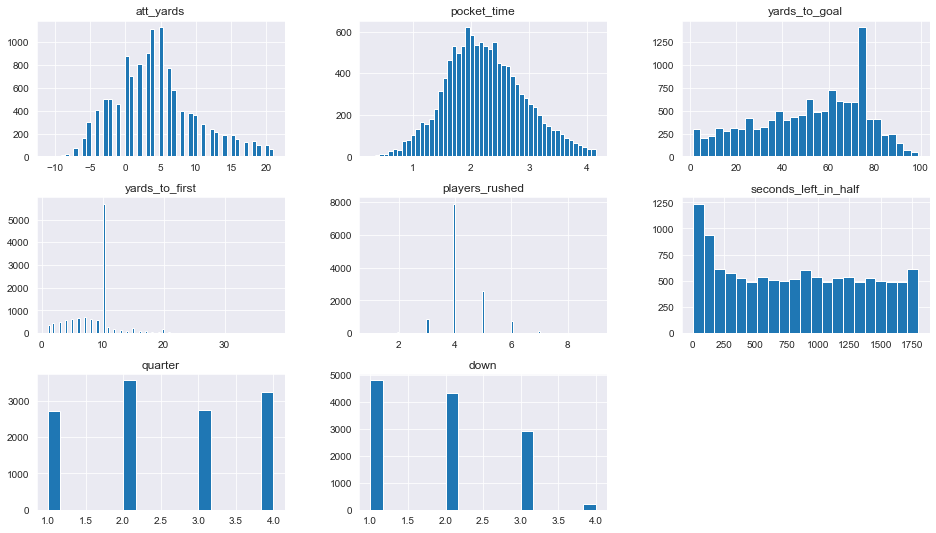

In [10]:
dfpre[scale_cols].hist(figsize=(16,9), bins='auto')

In [11]:
mms = MinMaxScaler()
scaled = mms.fit(dfpre[scale_cols])
scaled_cols = mms.transform(dfpre[scale_cols])
scaled_df = pd.DataFrame(scaled_cols, columns=scale_cols)

In [12]:
dfpre = dfpre.drop(scale_cols, axis=1)
df = pd.concat([dfpre, scaled_df], axis=1)
df

name  complete  inside_20  goaltogo  blitz_x  hurry  \
0      Aaron Rodgers       1.0        0.0       0.0      0.0    0.0   
1      Aaron Rodgers       1.0        1.0       0.0      0.0    0.0   
2      Aaron Rodgers       1.0        0.0       0.0      1.0    0.0   
3      Aaron Rodgers       1.0        0.0       0.0      0.0    0.0   
4      Aaron Rodgers       1.0        0.0       0.0      0.0    0.0   
...              ...       ...        ...       ...      ...    ...   
12240   Tyrod Taylor       1.0        0.0       0.0      0.0    0.0   
12241   Tyrod Taylor       1.0        0.0       0.0      0.0    0.0   
12242   Tyrod Taylor       1.0        0.0       0.0      0.0    0.0   
12243   Tyrod Taylor       1.0        0.0       0.0      1.0    0.0   
12244   Tyrod Taylor       0.0        0.0       0.0      0.0    0.0   

       knockdown  play_action  run_pass_option  blitz_y  \
0            0.0            0                0        0   
1            0.0            0                0        0   
2            0.0            0                0        1   
3            0.0            1                1        0   
4            0.0            0                0        0   
...          ...          ...              ...      ...   
12240        0.0            0                0        0   
12241        0.0            0                0        0   
12242        0.0            1                1        0   
12243        0.0            1                0        1   
12244        0.0            0                0        0   

       direction_deep middle  direction_deep right  direction_short left  \
0                          0                     0                     0   
1                          0                     0                     0   
2                          0                     0                     0   
3                          0                     0                     1   
4                          0                     0                     0   
...                      ...                   ...                   ...   
12240                      0                     0                     0   
12241                      0                     0                     0   
12242                      0                     0                     0   
12243                      0                     0                     0   
12244                      0                     0                     0   

       direction_short middle  direction_short right  hash_mark_Middle  \
0                           0                      1                 0   
1                           0                      1                 0   
2                           1                      0                 0   
3                           0                      0                 0   
4                           0                      1                 0   
...                       ...                    ...               ...   
12240                       1                      0                 0   
12241                       0                      1                 1   
12242                       0                      1                 0   
12243                       0                      1                 0   
12244                       0                      1                 0   

       hash_mark_Right Hash  qb_at_snap_Shotgun  qb_at_snap_Under Center  \
0                         1                   1                        0   
1                         0                   1                        0   
2                         0                   1                        0   
3                         1                   1                        0   
4                         0                   1                        0   
...                     ...                 ...                      ...   
12240                     1                   1                        0   
12241                     0                 

In [13]:
df.describe()

complete     inside_20      goaltogo       blitz_x         hurry  \
count  12245.000000  12245.000000  12245.000000  12245.000000  12245.000000   
mean       0.738097      0.122662      0.053001      0.301919      0.068109   
std        0.439688      0.328063      0.224045      0.459109      0.251944   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          knockdown   play_action  run_pass_option       blitz_y  \
count  12245.000000  12245.000000     12245.000000  12245.000000   
mean       0.075868      0.220580         0.067864      0.301919   
std        0.264797      0.414655         0.251523      0.459109   
min        0.000000      0.000000         0.000000      0.000000   
25%        0.000000      0.000000         0.000000      0.000000   
50%        0.000000      0.000000         0.000000      0.000000   
75%        0.000000      0.000000         0.000000      1.000000   
max        1.000000      1.000000         1.000000      1.000000   

       direction_deep middle  direction_deep right  direction_short left  \
count           12245.000000          12245.000000          12245.000000   
mean                0.009555              0.026215              0.363740   
std                 0.097285              0.159780              0.481095   
min                 0.000000              0.000000              0.000000   
25%                 0.000000              0.000000              0.000000   
50%                 0.000000              0.000000              0.000000   
75%                 0.000000              0.000000              1.000000   
max                 1.000000              1.000000              1.000000   

       direction_short middle  direction_short right  hash_mark_Middle  \
count            12245.000000           12245.000000      12245.000000   
mean                 0.197387               0.383177          0.114659   
std                  0.398043               0.486181          0.318623   
min                  0.000000               0.000000          0.000000   
25%                  0.000000               0.000000          0.000000   
50%                  0.000000               0.000000          0.000000   
75%                  0.000000               1.000000          0.000000   
max                  1.000000               1.000000          1.000000   

       hash_mark_Right Hash  qb_at_snap_Shotgun  qb_at_snap_Under Center  \
count          12245.000000        12245.000000             12245.000000   
mean               0.432258            0.813230                 0.172887   
std                0.495410            0.389743                 0.378165   
min                0.000000            0.000000                 0.000000   
25%                0.000000            1.000000                 0.000000   
50%                0.000000            1.000000                 0.000000   
75%                1.000000            1.000000                 0.000000   
max                1.000000            1.000000                 1.000000   

       pocket_location_Boot Right  pocket_location_Middle  \
count                12245.000000            12245.000000   
mean                     0.031196                0.884688   
std                      0.173855                0.319412   
min                      0.000000                0.000000   
25%                      0.000000                1.000000   
50%                      0.000000                1.000000   
75%                      0.000000                1.000000   
max                      1.000000                1.000000   

       pocket_location_Rollout Left  pocket_location_Rollout Right  \
count                  12245.

# Train-Test Split

In [14]:
X = df.drop(['name', 'complete'], axis=1)
y = df['complete']
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2,
                                      random_state=123)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9796, 42)
(2449, 42)
(9796,)
(2449,)


## Defining Helper Functions

In [16]:
def build_model(model, X, y, random_state=123, decision_function=True):
    
    X_train, X_test, y_train, y_test = tts(X, y, random_state=random_state,
                                           test_size=0.2)
    model_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if decision_function == True:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresh = roc_curve(y_test, y_score)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_ = auc(fpr,tpr)
    params = model.get_params()
    cfm = confusion_matrix(y_test, y_pred)
    
    model_dict['model'] = model
    model_dict['y_pred'] = y_pred
    model_dict['y_score'] = y_score
    model_dict['fpr'] = fpr
    model_dict['tpr'] = tpr
    model_dict['thresh'] = thresh
    model_dict['accuracy'] = acc
    model_dict['precision'] = pre
    model_dict['recall'] = rec
    model_dict['f1'] = f1
    model_dict['auc'] = auc_
    model_dict['params'] = params
    model_dict['cfm'] = cfm
    
    print(f'Accuracy: {round(acc, 3)}')
    print(f'Precision: {round(pre, 3)}')
    print(f'Recall: {round(rec, 3)}')
    print(f'F1 Score: {round(f1, 3)}')
    print(f'AUC: {round(auc_, 3)}')
    all_models.append(model_dict)
    
    return model_dict

In [17]:
def plot_matrix(cfm):
    
    labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['Incomplete', 'Complete']
    matrix = cm(cfm, group_names=labels, figsize=(10,6), fontsize=18,
               categories=categories, cbar=False, cmap='Purples')
    
    return matrix

# Baseline Model

In [18]:
all_models = []

In [19]:
baseline_log = build_model(LogisticRegression(random_state=123),X,y)

Accuracy: 0.757
Precision: 0.771
Recall: 0.96
F1 Score: 0.855
AUC: 0.69


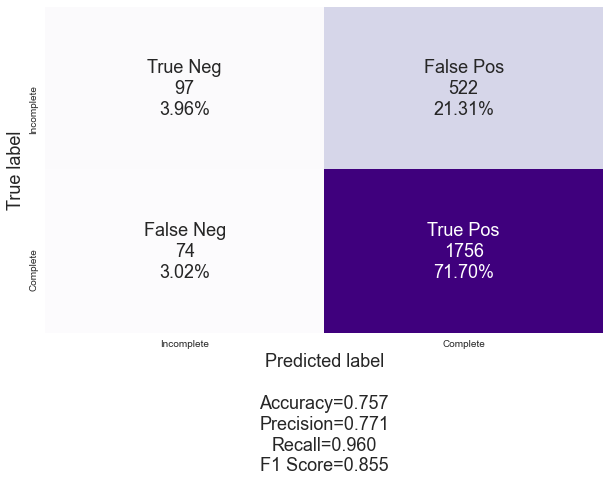

In [20]:
plot_matrix(baseline_log['cfm'])

## Determining Feature Importance

In [21]:
feature_names = X.columns
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

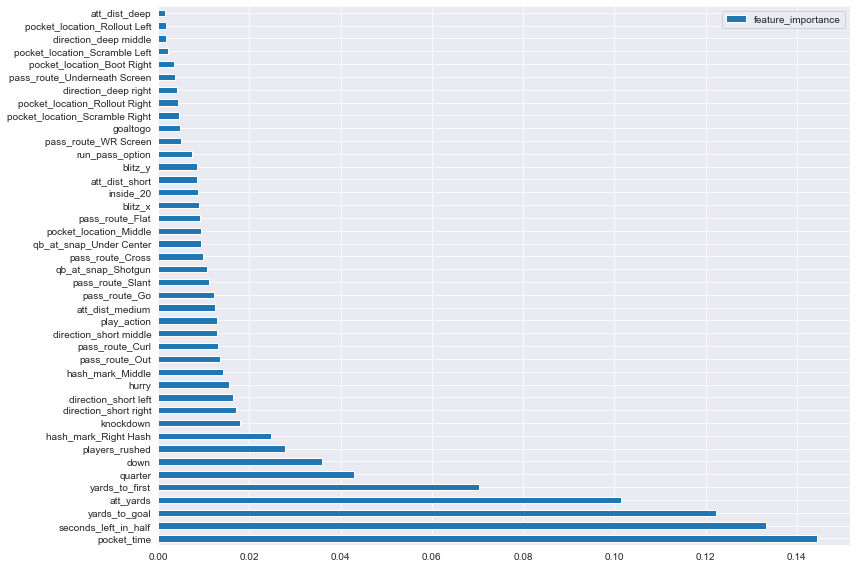

In [22]:
importances = forest.feature_importances_
forest_importances = pd.DataFrame(importances, index=feature_names, 
                                  columns=['feature_importance']
                                 ).sort_values('feature_importance', ascending=False)

fig, ax = plt.subplots(figsize=(12,8))
forest_importances.plot.barh(ax=ax)

fig.tight_layout()

In [23]:
top5 = forest_importances[:5]
ttop5 = top5.transpose()

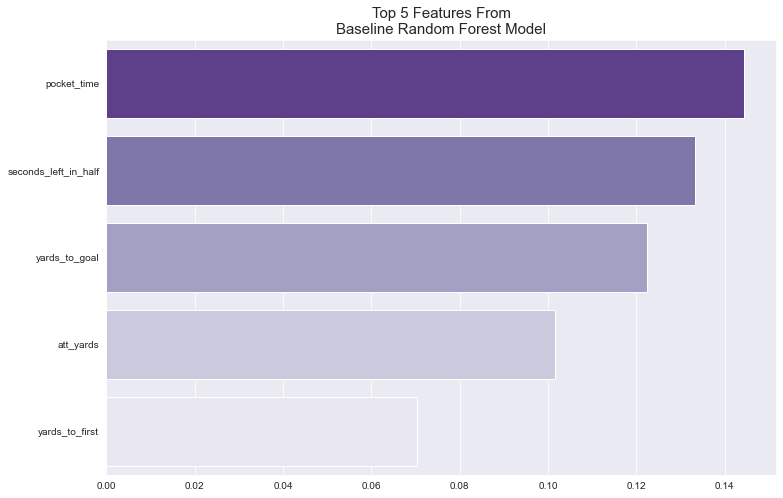

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(data=ttop5, orient='h', palette='Purples_r')

plt.title('Top 5 Features From\nBaseline Random Forest Model', fontsize=15)

plt.savefig('./Images/feature_importance.png', format='png')
plt.show()

In [25]:
top5 = top5.index

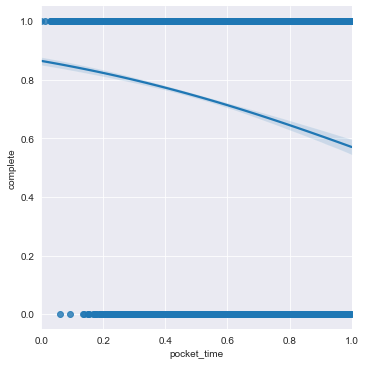

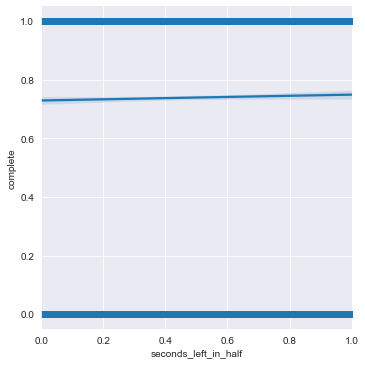

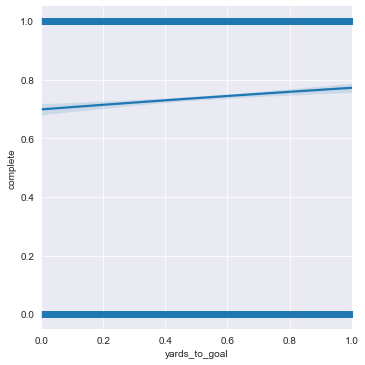

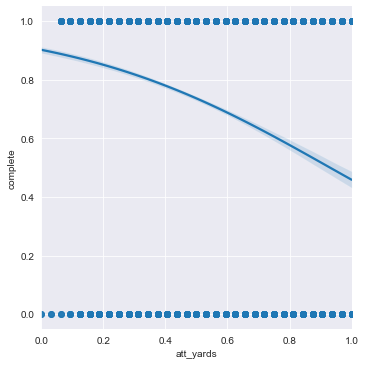

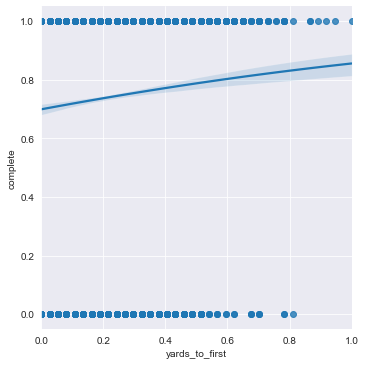

In [26]:
sns.lmplot(x='pocket_time', y='complete', data=df, logistic=True, aspect=1)
sns.lmplot(x='seconds_left_in_half', y='complete', data=df, logistic=True, aspect=1)
sns.lmplot(x='yards_to_goal', y='complete', data=df, logistic=True, aspect=1)
sns.lmplot(x='att_yards', y='complete', data=df, logistic=True, aspect=1)
sns.lmplot(x='yards_to_first', y='complete', data=df, logistic=True, aspect=1)



# plt.xlabel('Pocket Time (sec)')
# plt.ylabel('Completion Rate')
# plt.title('Change in Completion Rate vs Time in Pocket')
# plt.savefig('./Images/complete_vs_pocket_time.png', format='png')
# plt.show()

## Logistic Regression Top 5 Features

In [27]:
top5_log = build_model(LogisticRegression(random_state=123),X[top5],y )

Accuracy: 0.748
Precision: 0.754
Recall: 0.983
F1 Score: 0.853
AUC: 0.64


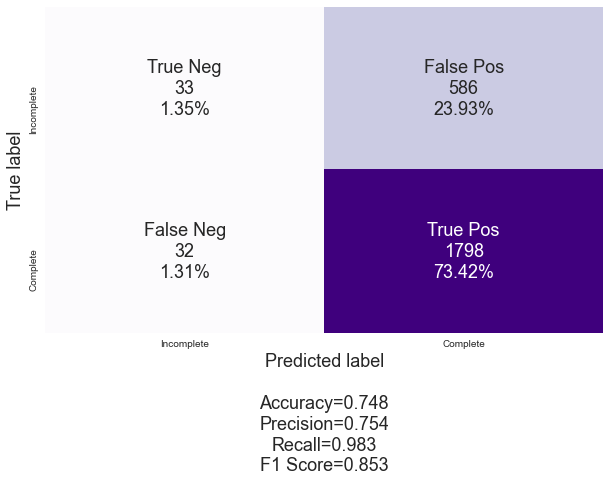

In [28]:
plot_matrix(top5_log['cfm'])

## Random Forest Top 5 Features

In [29]:
top5_rf = build_model(RandomForestClassifier(
                                             n_estimators=500,
                                             criterion='gini',
                                             random_state=123),
                      X[top5],y, decision_function=False)

Accuracy: 0.739
Precision: 0.766
Recall: 0.937
F1 Score: 0.843
AUC: 0.64


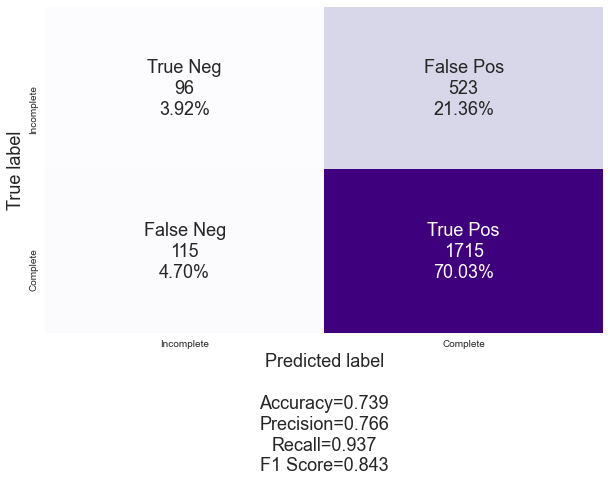

In [30]:
plot_matrix(top5_rf['cfm'])

## KNN Top 5 Features

In [31]:
top5_knn = build_model(KNeighborsClassifier(), X[top5], y, decision_function=False)

Accuracy: 0.72
Precision: 0.772
Recall: 0.886
F1 Score: 0.825
AUC: 0.598


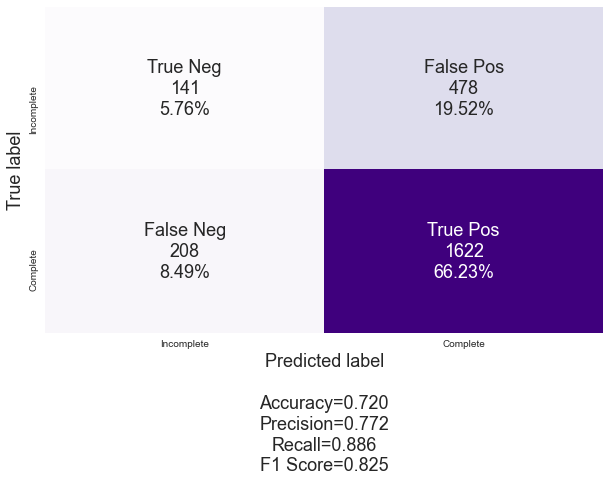

In [32]:
plot_matrix(top5_knn['cfm'])

## Decision Tree Classifier Top 5 Features

In [33]:
top5_tree = build_model(DecisionTreeClassifier(
                                               random_state=123),
                        X[top5], y, decision_function=False)

Accuracy: 0.639
Precision: 0.769
Recall: 0.739
F1 Score: 0.754
AUC: 0.541


In [34]:
top5_tree['model'].predict_proba(X_test[top5])

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

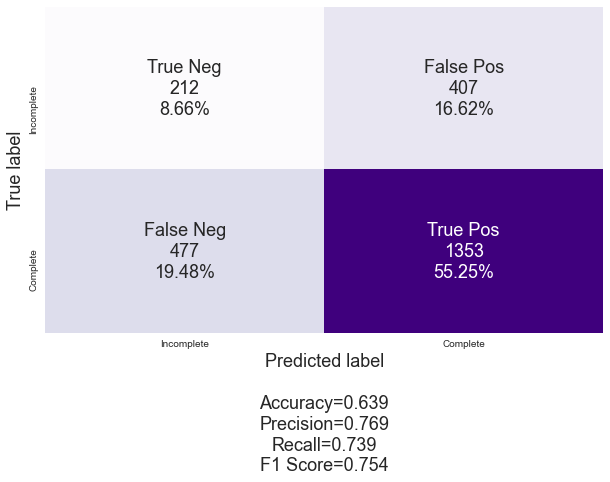

In [35]:
plot_matrix(top5_tree['cfm'])

## Gradient Boosting Classifier Top 5 Features

In [36]:
top5_gb = build_model(GradientBoostingClassifier(random_state=123,
                                                 n_estimators=1000),X[top5], y)

Accuracy: 0.732
Precision: 0.763
Recall: 0.931
F1 Score: 0.839
AUC: 0.622


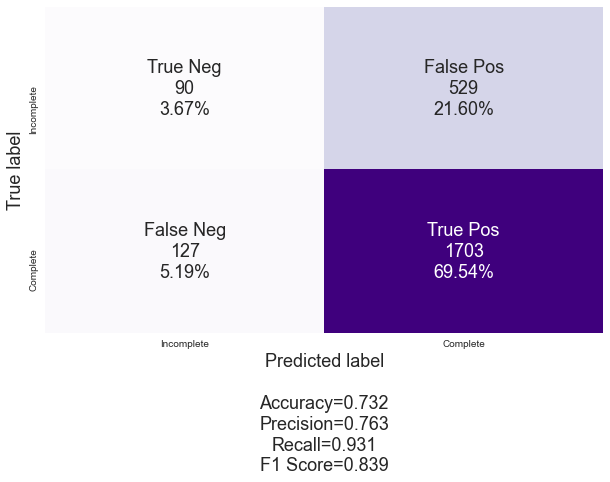

In [37]:
plot_matrix(top5_gb['cfm'])

## AdaBoost Classifier

In [38]:
top5_ada = build_model(AdaBoostClassifier(random_state=123),
                       X[top5], y)

Accuracy: 0.749
Precision: 0.755
Recall: 0.984
F1 Score: 0.854
AUC: 0.655


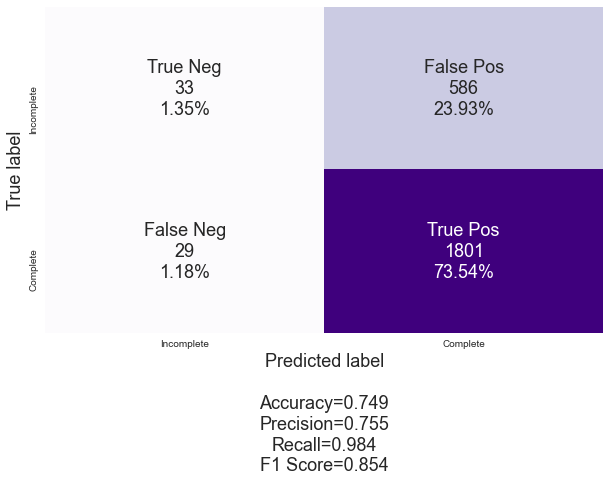

In [39]:
plot_matrix(top5_ada['cfm'])

## XGBoost Classifier Top 5 Features

In [40]:
top5_xgb = build_model(xgb.XGBClassifier(random_state=123,
                                         n_estimators=500),
                       X[top5], y, decision_function=False)

[11:08:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/scott/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.703
Precision: 0.767
Recall: 0.864
F1 Score: 0.813
AUC: 0.597


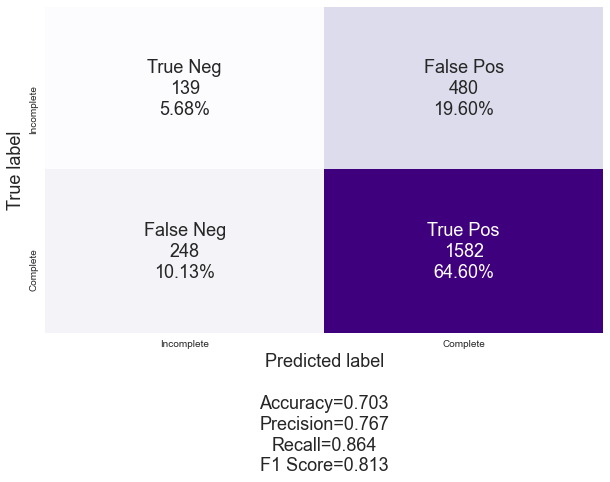

In [41]:
plot_matrix(top5_xgb['cfm'])

# GridSearchCV on Log and Ada Classifiers

In [42]:
X_train, X_test, y_train, y_test = tts(X[top5], y, test_size=0.2, random_state=123)

In [43]:
log_pipe = Pipeline([('log', LogisticRegression(random_state=123))])

param_grid = [
    {'log__penalty' : ['l1', 'l2'],
     'log__solver' : ['liblinear', 'lbfgs'],
     'log__C' : [0.001, 0.01, 0.1, 1],
     'log__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
     'log__max_iter' : list(range(50, 101, 10))}
]


gs_log = GridSearchCV(log_pipe, 
                      param_grid=param_grid,
                      scoring='f1',
                      cv=5, verbose=False, n_jobs=-1)

gs_log.fit(X_train, y_train)
gs_log.best_params_
# best_model = buid_model(clf, X[top5])

/Users/scott/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.8478005  0.8478005  0.8478005  0.8478005  0.8478005         nan
        nan        nan        nan        nan 0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005         nan        nan        nan        nan        nan
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005         nan        nan        nan
        nan        nan 0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.8478005  0.8478005         nan
        nan        nan        nan        nan 0.8478005  0.8478005
 0.8478005  0.8478005  0.8478005  0.847

{'log__C': 0.001,
 'log__max_iter': 50,
 'log__penalty': 'l1',
 'log__solver': 'liblinear',
 'log__tol': 0.0001}

In [44]:
gs_log.score(X_train, y_train)

0.8478005175252882

In [45]:
test = build_model(gs_log.best_estimator_, X[top5], y, decision_function=False)

Accuracy: 0.747
Precision: 0.747
Recall: 1.0
F1 Score: 0.855
AUC: 0.5


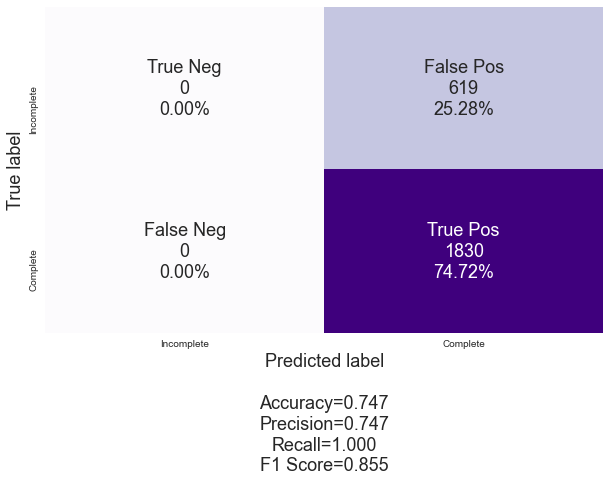

In [46]:
plot_matrix(test['cfm'])

Gridsearch models are returning near perfect recall scores. The models are heavily favoring the positive cases.

# Dealing With Class Imbalance Using SMOTE

Accuracy: 0.693
Precision: 0.774
Recall: 0.832
F1 Score: 0.802
AUC: 0.618


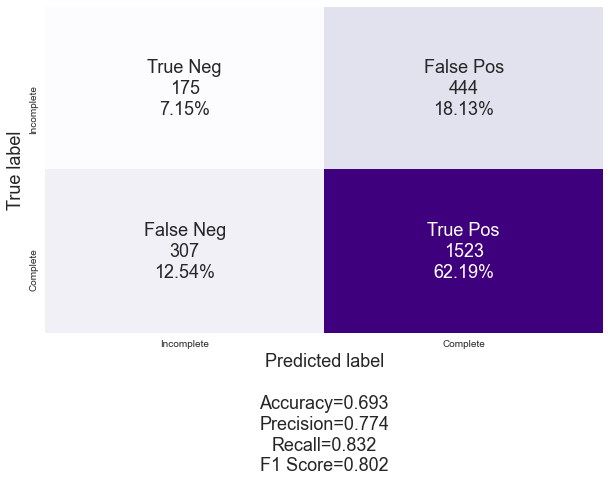

In [47]:
from imblearn.pipeline import Pipeline

smt = SMOTE(random_state=123)
rf = RandomForestClassifier(random_state=123)
pipe = Pipeline([('smt', smt), ('rf', rf)])
rf_smote_pipe = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(rf_smote_pipe['cfm'])

Accuracy: 0.605
Precision: 0.808
Recall: 0.619
F1 Score: 0.701
AUC: 0.641


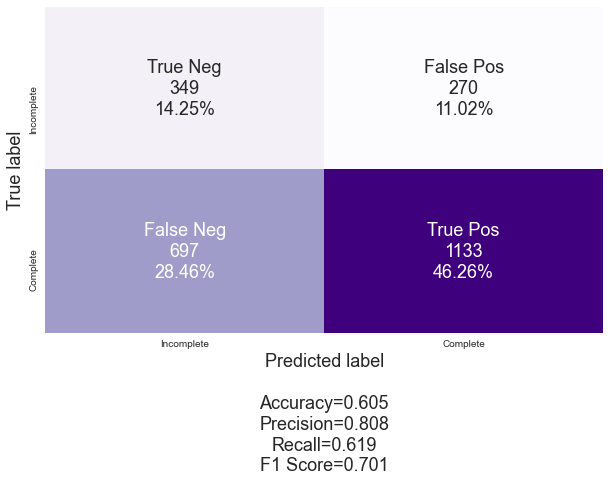

In [48]:
clf = LogisticRegression(random_state=123)
pipe = Pipeline([('smt', smt), ('clf', clf)])
log_smote_pipe = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(log_smote_pipe['cfm'])

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

n_estimators = list(range(100,1001,100))
max_features = ['auto', 'sqrt']
max_depth = list(range(10,111,10))
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = ['True', 'False']

random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

smt = SMOTE(random_state=123)
under = RandomUnderSampler(random_state=123)
rf = RandomForestClassifier(random_state=123)
pipe = Pipeline([('smt', smt), ('under', under), ('rf', rf)])

rf_random = RandomizedSearchCV(estimator=pipe,
                               param_distributions=random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 2,
                               n_jobs = -1,
                               scoring = 'accuracy',
                               random_state=123)


In [51]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smt', SMOTE(random_state=123)),
                                             ('under',
                                              RandomUnderSampler(random_state=123)),
                                             ('rf',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__bootstrap': ['True', 'False'],
                                        'rf__max_depth': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100,
                                                          110],
                                        'rf__max_features': ['auto', 'sqrt'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf_

In [52]:
rf_random.best_params_

{'rf__n_estimators': 1000,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 20,
 'rf__bootstrap': 'False'}

In [53]:
rf_random.best_estimator_['rf']

RandomForestClassifier(bootstrap='False', max_depth=20, max_features='sqrt',
                       min_samples_split=10, n_estimators=1000,
                       random_state=123)

# Undersample Majority in Random Forest Pipeline

Accuracy: 0.707
Precision: 0.779
Recall: 0.848
F1 Score: 0.812
AUC: 0.638


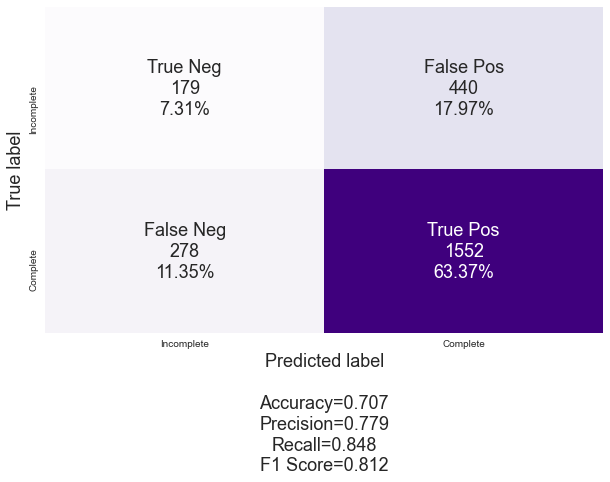

In [54]:
rf = rf_random.best_estimator_['rf']
pipe = Pipeline([('smt', smt), ('under', under), ('rf', rf)])
rf_overUnder = build_model(pipe, X[top5], y, decision_function=False)
plot_matrix(rf_overUnder['cfm'])

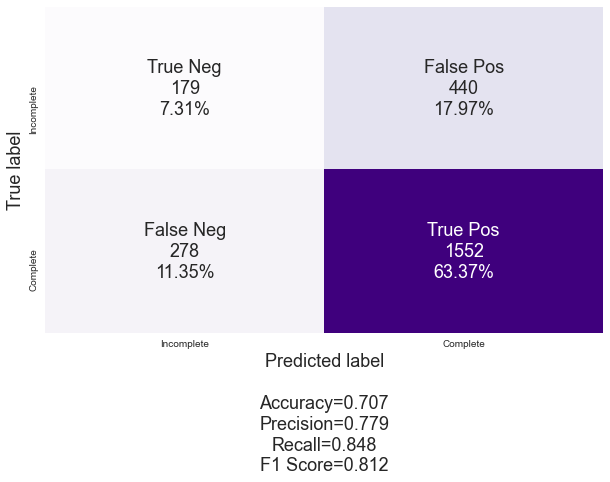

In [55]:
fig = plot_matrix(rf_overUnder['cfm'])
plt.savefig('./Images/final_cm.png', format='png')

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='recall', cv=cv, n_jobs=-1)
print(f'Mean recall: {round(np.mean(scores),3)}')

Mean recall: 0.848


In [57]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='precision', cv=cv, n_jobs=-1)
print(f'Mean precision: {round(np.mean(scores),3)}')

Mean precision: 0.772


In [58]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(pipe, X[top5], y, scoring='f1', cv=cv, n_jobs=-1)
print(f'Mean f1: {round(np.mean(scores),3)}')

Mean f1: 0.808


In [59]:
qb_avg = y.value_counts(normalize=True)[1]

In [60]:
print(f'Mean accuracy of Random Forest model: {round(np.mean(scores),3)}')
print(f'Average completion rate of dataset: {round(qb_avg,3)}')

Mean accuracy of Random Forest model: 0.808
Average completion rate of dataset: 0.738


Performed worse than if model were to predict all complete passes.

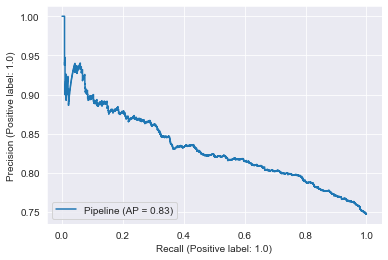

In [63]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(rf_overUnder['model'], X_test, y_test)

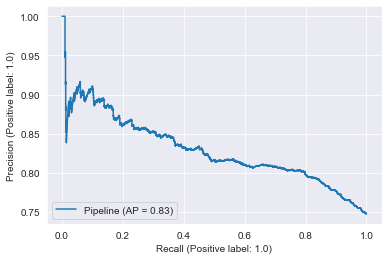

In [64]:
log = LogisticRegression(random_state=123)
pipe = Pipeline([('smt', smt), ('under', under), ('log', log)])

X_train, X_test, y_train, y_test = tts(X[top5], y, test_size=0.2, random_state=123)
pipe.fit(X_train, y_train)
plot_precision_recall_curve(pipe, X_test, y_test)

In [71]:
build_model(pipe, X[top5], y)

Accuracy: 0.605
Precision: 0.808
Recall: 0.619
F1 Score: 0.701
AUC: 0.641


{'model': Pipeline(steps=[('smt', SMOTE(random_state=123)),
                 ('under', RandomUnderSampler(random_state=123)),
                 ('log', LogisticRegression(random_state=123))]),
 'y_pred': array([0., 1., 1., ..., 1., 1., 0.]),
 'y_score': array([-0.09813658,  0.30566481,  0.57212085, ...,  0.37101042,
         0.74086842, -0.46388458]),
 'fpr': array([0.        , 0.        , 0.        , 0.00161551, 0.00161551,
        0.00323102, 0.00323102, 0.00484653, 0.00484653, 0.00646204,
        0.00646204, 0.00807754, 0.00807754, 0.00969305, 0.00969305,
        0.01130856, 0.01130856, 0.01292407, 0.01292407, 0.01453958,
        0.01453958, 0.01615509, 0.01615509, 0.01938611, 0.01938611,
        0.02100162, 0.02100162, 0.02261712, 0.02261712, 0.02423263,
        0.02423263, 0.02584814, 0.02584814, 0.02746365, 0.02746365,
        0.02907916, 0.02907916, 0.03069467, 0.03069467, 0.03231018,
        0.03231018, 0.03392569, 0.03392569, 0.0355412 , 0.0355412 ,
        0.0371567 , 0.037156

In [80]:
df_models = pd.DataFrame(all_models)
df_models = df_models.loc[:,['model', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'params', 'cfm']]

In [82]:
df_models.sort_values('precision', ascending=False)

model  accuracy  precision  \
10  (SMOTE(random_state=123), LogisticRegression(r...  0.605145   0.807555   
12  (SMOTE(random_state=123), RandomUnderSampler(r...  0.605145   0.807555   
11  (SMOTE(random_state=123), RandomUnderSampler(r...  0.706819   0.779116   
9   (SMOTE(random_state=123), (DecisionTreeClassif...  0.693344   0.774276   
3                              KNeighborsClassifier()  0.719886   0.772381   
0                LogisticRegression(random_state=123)  0.756635   0.770852   
4            DecisionTreeClassifier(random_state=123)  0.639036   0.768750   
7   XGBClassifier(base_score=0.5, booster='gbtree'...  0.702736   0.767216   
2   (DecisionTreeClassifier(max_features='auto', r...  0.739486   0.766309   
5   ([DecisionTreeRegressor(criterion='friedman_ms...  0.732136   0.762993   
6   (DecisionTreeClassifier(max_depth=1, random_st...  0.748877   0.754504   
1                LogisticRegression(random_state=123)  0.747652   0.754195   
8   (LogisticRegression(C=0.001, max_iter=50, pena...  0.747244   0.747244   

      recall        f1       auc  \
10  0.619126  0.700897  0.640874   
12  0.619126  0.700897  0.640874   
11  0.848087  0.812140  0.637988   
9   0.832240  0.802212  0.617813   
3   0.886339  0.825445  0.597734   
0   0.959563  0.854917  0.690260   
4   0.739344  0.753760  0.540916   
7   0.864481  0.812950  0.597406   
2   0.937158  0.843166  0.639858   
5   0.930601  0.838503  0.621763   
6   0.984153  0.854162  0.654977   
1   0.982514  0.853346  0.640149   
8   1.000000  0.855340  0.500000   

                                               params  \
10  {'memory': None, 'steps': [('smt', SMOTE(rando...   
12  {'memory': None, 'steps': [('smt', SMOTE(rando...   
11  {'memory': None, 'steps': [('smt', SMOTE(rando...   
9   {'memory': None, 'steps': [('smt', SMOTE(rando...   
3   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
0   {'C': 1.0, 'class_weight': None, 'dual': False...   
4   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   
7   {'objective': 'binary:logistic', 'use_label_en...   
2   {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   
5   {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...   
6   {'algorithm': 'SAMME.R', 'base_estimator': Non...   
1   {'C': 1.0, 'class_weight': None, 'dual': False...   
8   {'memory': None, 'steps': [('log', LogisticReg...   

                          cfm  
10  [[349, 270], [697, 1133]]  
12  [[349, 270], [697, 1133]]  
11  [[179, 440], [278, 1552]]  
9   [[175, 444], [307, 1523]]  
3   [[141, 478], [208, 1622]]  
0     [[97, 522], [74, 1756]]  
4   [[212, 407], [477, 1353]]  
7   [[139, 480], [248, 1582]]  
2    [[96, 523], [115, 1715]]  
5    [[90, 529], [127, 1703]]  
6     [[33, 586], [29, 1801]]  
1     [[33, 586], [32, 1798]]  
8       [[0, 619], [0, 1830]]

1. gridsearch logreg models with high precision
2. code predict_proba with best model
    - input: game situation (down, quarter, etc.)
    - output: probability that pass will be completed
        - loop through all 6 directions to find probability of each
3. make 3 business recommendations
    - base off eda, not model

# Recommendations


need to be able to justify/explain reasoning behind metric of choice

- can be situational
    - in x situation, use model A
    - in y situation, use model B
    
3 business recommendations from EDA, not model analysis

In [ ]:
top5_log['model'].predict_proba(X_test[top5])

3 down 5:14 4th quarter 25 yards to goal = % complete pass